#### Install dependencies

In [1]:
# Install dependencies
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import os
import ast
import calendar

#### Load data

In [2]:
# Load data

# Set the style for seaborn
sns.set(style="white")

# Get the absolute path to the directory containing the notebook
notebook_dir = os.path.dirname(os.path.abspath("__file__"))  # Or hardcode if needed

# Construct the full path to the CSV file
csv_path = os.path.join(notebook_dir, 'df_fusion.csv')

# Load the dataset
df = pd.read_csv(csv_path)

# Display full columns of the dataset
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# Display the first few row of the dataset
# df.head()

In [3]:
df.isna().sum()

film_id                                0
film_title                             0
image_url                              0
year_of_production                     0
release_date_france                 3009
release_date_usa                    2460
nationality                         3467
languages                              0
duration                               9
age_classification                  4408
director                               6
top_stars                             72
producers                              6
main_genre_jpboxoffice                 0
associated_genres_allocine             0
synopsis                               3
filming_secrets                        0
awards                              2903
broadcast_category                     0
distributor                          150
budget                              2042
fr_entries                             0
fr_entries_cumul                    4926
fr_entry_week                        602
us_entries      

#### Rename columns

In [3]:
df.rename(columns={"month_name": "fr_entry_week_month",
            "release_month": "release_date_france_month"}, inplace=True)

#### Create new columns from date objects

In [4]:
# Convert to datetime
df['release_date_france'] = pd.to_datetime(df['release_date_france'], errors='coerce')
df['release_date_usa'] = pd.to_datetime(df['release_date_usa'], errors='coerce')

# Extract year
df['release_date_france_year'] = df['release_date_france'].dt.year
df['release_date_usa_year'] = df['release_date_usa'].dt.year
df['release_date_usa_month'] = df['release_date_usa'].dt.month

# Map 'release_date_usa_month' to the month name
df['release_date_usa_month'] = df['release_date_usa_month'].map(lambda x: calendar.month_name[int(x)] if pd.notnull(x) else np.nan)

# Before extracting usa entry week month, standardize the dash in case it's an en-dash or em-dash
df['us_entry_week'] = df['us_entry_week'].str.replace('–', '-', regex=False)

# Extract the first date and convert it to datetime, then get the month name
df['us_entry_week_month'] = pd.to_datetime(df['us_entry_week'].str.extract(r'(\d{2}-\d{2}-\d{4})')[0], 
                                            errors='coerce', dayfirst=True).dt.month_name()

#### Drop columns not needed

In [5]:
# Drop release_date related columns
df.drop(columns=['release_date_us', 'release_date_france', 'release_date_usa'], axis=1, inplace=True)

# Drop columns already transformed into lists
df.drop(columns=['nationality', 'languages', 'top_stars', 'producers', 'associated_genres_allocine'], 
        axis=1, 
        inplace=True)

# Drop columns with key numbers extracted
df.drop(columns=['budget', 'duration', 'viewer_critics_count', 'press_critics_count', 'awards', 
                 'total_awards_nomination', 'filming_secrets', 'age_classification', 'trailer_views', 
                 'fr_entry_month', 'fr_entries_cumul', 'fr_entries', 'us_entries',
                 'revenue_usa', 'revenue_world', 'fr_entry_week', 'fr_entry_week_iso_week', 'fr_entry_week_month', 
                 'us_entry_week', 'us_entry_week_month', 'us_entry_week_iso_week', 'opening_week_us_num',
                 'release_date_usa_year', 'release_date_usa_month', 'release_timing_category',
                 'release_diff', 'image_url',], 
        axis=1, 
        inplace=True)

#### Re-order columns

In [6]:
ordered_columns = [
    # Basic info
    'film_id', 'film_title', 'year_of_production',
    
    # Release info
    'release_date_france_year', 'release_date_france_month', 'release_season',
    
    # Nationality & language
    'nationality_list', 'nationality_list_count',
    'languages_list', 'languages_count',
    
    # Cast & crew
    'director', 'top_stars_list', 'top_stars_count',
    'producers_list', 'producers_count',
    
    # Genre & categories
    'main_genre_jpboxoffice',
    'associated_genres_allocine_list', 'associated_genres_allocine_count',
    'broadcast_category', 'distributor', 'age_class_grouped',
    
    # Synopsis & extras
    'synopsis', 'synopsis_length', 'synopsis_sentiment',
    'filming_secrets_num',
    
    # Awards
    'award_count', 'nomination_count',
    
    # Entries
    'opening_week_france_num',
    
    # Ratings
    'press_rating', 'press_critics_count_num',
    'viewer_rating', 'viewer_notes', 'viewer_critiques',
    
    # Trailer
    'trailer_views_num',
    
    # Duration
    'duration_minutes'
]
df = df[ordered_columns]

#### Categorize duration

In [7]:
def categorize_duration(duration):
    if duration < 70:
        return "short-film"
    elif 70 < duration < 160:
        return "normal-film"
    elif 160 < duration < 210:
        return "long-film"
    else:
        return "very long film"
    
df['duration_classified'] = df['duration_minutes'].apply(lambda x: categorize_duration(x))

#### Categorize trailer views

In [8]:
def categorize_trailer_views(trailer_views):
    if trailer_views != np.nan:
        return "likely to impact" if trailer_views <= 150000.0 else "not likely to impact"
        
df['trailer_views_categorized'] = df['trailer_views_num'].apply(lambda x: categorize_trailer_views(x))

#### Categorize filming_secrets

In [9]:
def categorize_filming_secrets(filming_secrets):
    if filming_secrets != np.nan:
        return "likely to impact" if filming_secrets > 30 else "not likely to impact"
        
df['filming_secrets_categorized'] = df['filming_secrets_num'].apply(lambda x: categorize_filming_secrets(x))

#### Categorize synopsis

In [10]:
def categorize_synopsis_length(num):
    if num != np.nan:
        if num <= 200:
            return "not long"
        elif 200 < num < 700:
            return "normal"
        elif 700 < num < 1000:
            return "long"
        else:
            return "very long"
              
def categorize_synopsis_sentiment(num):
    if num != np.nan:
        if num <= -0.2:
            return "negative"
        elif -0.2 < num < 0.2:
            return "neutral"
        elif 0.2 < num < 0.5:
            return "positive"
        else:
            return "very positive"
        
df['synopsis_length_categorized'] = df['synopsis_length'].apply(lambda x: categorize_synopsis_length(x))
df['synopisis_sentiment_categorized'] = df['synopsis_sentiment'].apply(lambda x: categorize_synopsis_sentiment(x))

#### Categorize award and nomination

In [11]:
def categorize_award_and_nomination(num):
    if num != np.nan:
        if num == 0:
            return 0
        elif num > 0:
            return 1
        
df['award_categorized'] = df['award_count'].apply(lambda x: categorize_award_and_nomination(x))
df['nomination_categorized'] = df['nomination_count'].apply(lambda x: categorize_award_and_nomination(x))

#### Calculate F-statistic for categorical variables

In [ ]:
# Set standard columns
f_stat_groups = [
                'director', 'broadcast_category', 'main_genre_jpboxoffice', 
                'release_date_france_month', 'release_date_france_year',
                'release_season', 'distributor', 
                'duration_classified', 'age_class_grouped', 
                'synopsis_length_categorized', 'synopisis_sentiment_categorized',
                'trailer_views_categorized', 'filming_secrets_categorized',
                'award_categorized', 'nomination_categorized',
]
    
     
# Set exploded list-like columns
list_columns = [
    'producers_list', 'top_stars_list', 'languages_list',
    'nationality_list', 'associated_genres_allocine_list' 
]

results = []

# Run ANOVA on standard columns
for col in f_stat_groups:
    grouped = df.groupby(col)['opening_week_france_num']
    valid_groups = [group.fillna('unavailable') for name, group in grouped if len(group.fillna('unavailable')) >= 2]
    if len(valid_groups) >= 2:
        anova_result = stats.f_oneway(*valid_groups)
        results.append({'feature': col, 'F-statistic': anova_result.statistic, 'p-value': anova_result.pvalue})

# Run ANOVA on Exploded list columns
for col in list_columns:
    exploded_df = df.explode(col)
    grouped = exploded_df.groupby(col)['opening_week_france_num']
    valid_groups = [group.fillna('unavailable') for name, group in grouped if len(group.fillna('unavailable')) >= 3]
    if len(valid_groups) >= 2:
        anova_result = stats.f_oneway(*valid_groups)
        results.append(
            {
                'feature': f'{col} (exploded)',
                'F-statistic': anova_result.statistic,
                'p-value': anova_result.pvalue,
            }
        )

# Combine results into a single DataFrame
fstat_df = pd.DataFrame(results).sort_values(by='F-statistic', ascending=False).reset_index(drop=True)

print(fstat_df)


                                       feature  F-statistic        p-value
0                  filming_secrets_categorized   148.833788   9.418228e-34
1                       main_genre_jpboxoffice   125.848579  4.972487e-214
2                       nomination_categorized    69.606035   9.279448e-17
3                    trailer_views_categorized    58.522921   2.397160e-14
4                            award_categorized    41.400630   1.356565e-10
5                    top_stars_list (exploded)    34.576749   4.394284e-26
6                          duration_classified    23.160874   6.957633e-15
7   associated_genres_allocine_list (exploded)    11.548619  9.104338e-228
8                  synopsis_length_categorized     9.041705   5.735401e-06
9                                  distributor     8.336389  4.558868e-146
10                   producers_list (exploded)     6.023561   8.008600e-54
11             synopisis_sentiment_categorized     5.582329   8.066954e-04
12                       

#### Check for multicollinearity between numerical columns

In [14]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.impute import SimpleImputer

# Ensure no non-numeric columns and no missing values
X = df[['year_of_production',
        'nationality_list_count', 'languages_count', 'top_stars_count', 'producers_count',
        'associated_genres_allocine_count', 'synopsis_length', 'synopsis_sentiment', 'filming_secrets_num',
        'award_count', 'nomination_count', 'duration_minutes', 'trailer_views_num', 
        ]]

imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Add a constant for statsmodels compatibility
X_const = add_constant(X_imputed)

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i+1) for i in range(len(X.columns))]

# Display VIFs sorted from highest to lowest
print(vif_data.sort_values(by="VIF", ascending=False))

                             Feature       VIF
10                  nomination_count  1.908257
9                        award_count  1.802251
11                  duration_minutes  1.263774
8                filming_secrets_num  1.203658
3                    top_stars_count  1.153215
5   associated_genres_allocine_count  1.100862
2                    languages_count  1.087652
1             nationality_list_count  1.080709
4                    producers_count  1.075937
0                 year_of_production  1.057049
6                    synopsis_length  1.054694
7                 synopsis_sentiment  1.005889
12                 trailer_views_num  1.001463


#### Calculate mutual info regression on numerical columns

In [21]:
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler

# Define your feature set and target
X = df[['film_id', 'year_of_production', 'release_date_france_year', 
        'nationality_list_count', 'languages_count', 'top_stars_count', 'producers_count',
        'associated_genres_allocine_count', 'synopsis_length', 'synopsis_sentiment', 'filming_secrets_num',
        'award_count', 'nomination_count', 
        'duration_minutes', 'trailer_views_num',]]

y = df.loc[X.index, 'opening_week_france_num']

# Impute missing values using median
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Standard scaling for each column
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X.columns)

# Calculate Mutual Information
mi = mutual_info_regression(X_scaled, y)

# Create a DataFrame with sorted MI values
mi_df = pd.DataFrame({'Feature': X.columns, 'Mutual Information': mi})
mi_df['Mutual Information'] = mi_df['Mutual Information'].round(2)
mi_df = mi_df.sort_values(by='Mutual Information', ascending=False)

# Display the result
print(mi_df)

                             Feature  Mutual Information
0                            film_id                0.16
10               filming_secrets_num                0.11
13                  duration_minutes                0.05
14                 trailer_views_num                0.03
12                  nomination_count                0.03
6                    producers_count                0.03
3             nationality_list_count                0.02
7   associated_genres_allocine_count                0.02
5                    top_stars_count                0.02
1                 year_of_production                0.01
4                    languages_count                0.01
11                       award_count                0.01
9                 synopsis_sentiment                0.01
2           release_date_france_year                0.00
8                    synopsis_length                0.00


#### Calculate correlation coefficients on numerical columns

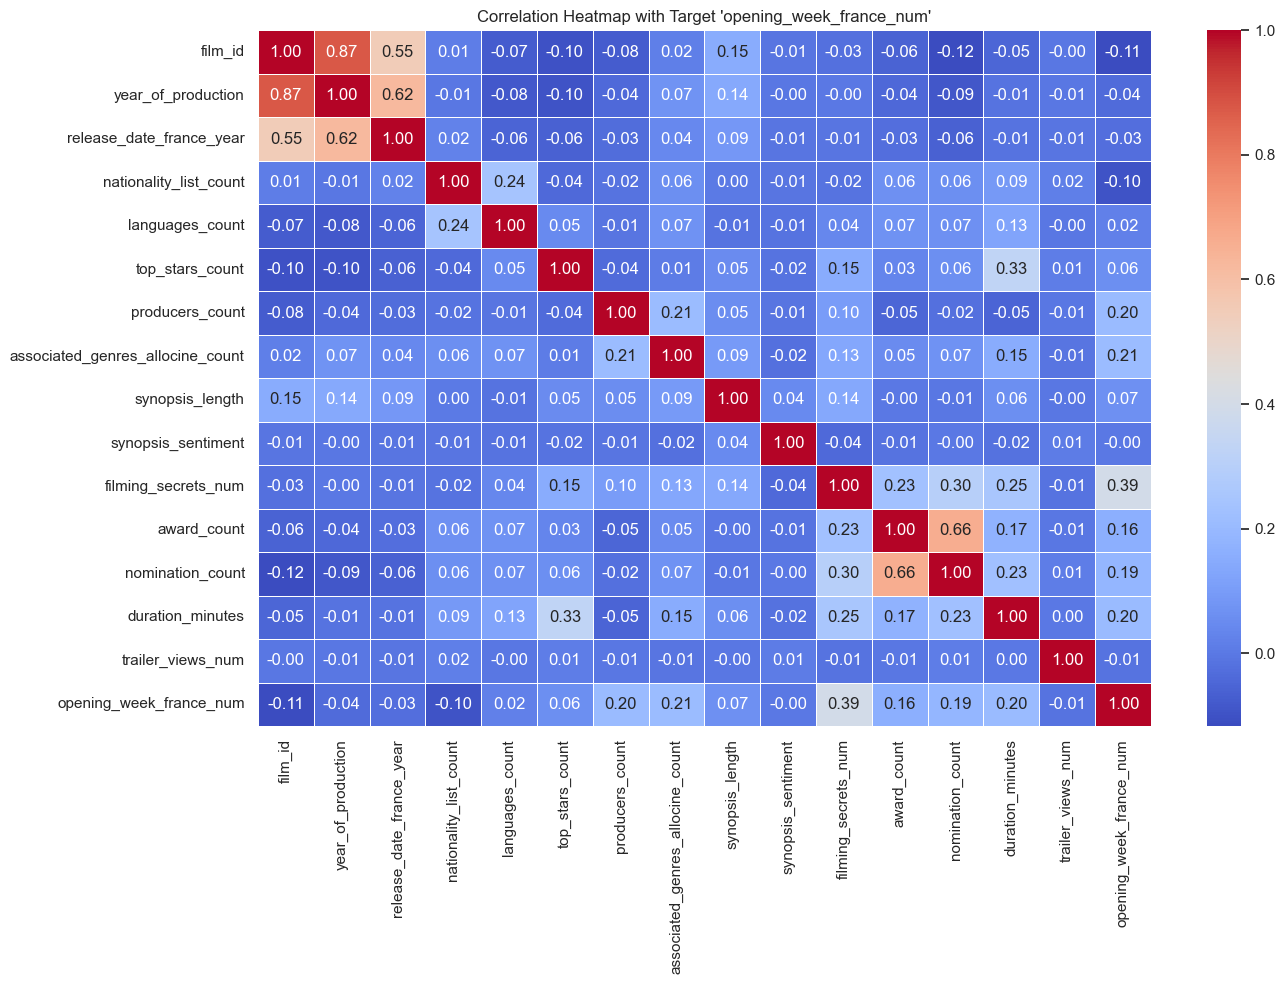

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Define features and target
X = df[['film_id', 'year_of_production', 'release_date_france_year',  
        'nationality_list_count', 'languages_count', 'top_stars_count', 'producers_count',
        'associated_genres_allocine_count', 'synopsis_length', 'synopsis_sentiment', 'filming_secrets_num',
        'award_count', 'nomination_count', 
        'duration_minutes', 'trailer_views_num', ]]

y = df['opening_week_france_num']

# Impute missing values using median
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Standard scaling
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X.columns)

# Add the target back to the scaled DataFrame (not scaled, but imputed)
df_corr = X_scaled.copy()
df_corr['opening_week_france_num'] = y.reset_index(drop=True)

# Drop rows with NaN in the target before correlation
df_corr = df_corr.dropna(subset=['opening_week_france_num'])

# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(df_corr.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Heatmap with Target 'opening_week_france_num'")
plt.tight_layout()
plt.show()

#### Compare MIR and correlation results to choose numerical predictors

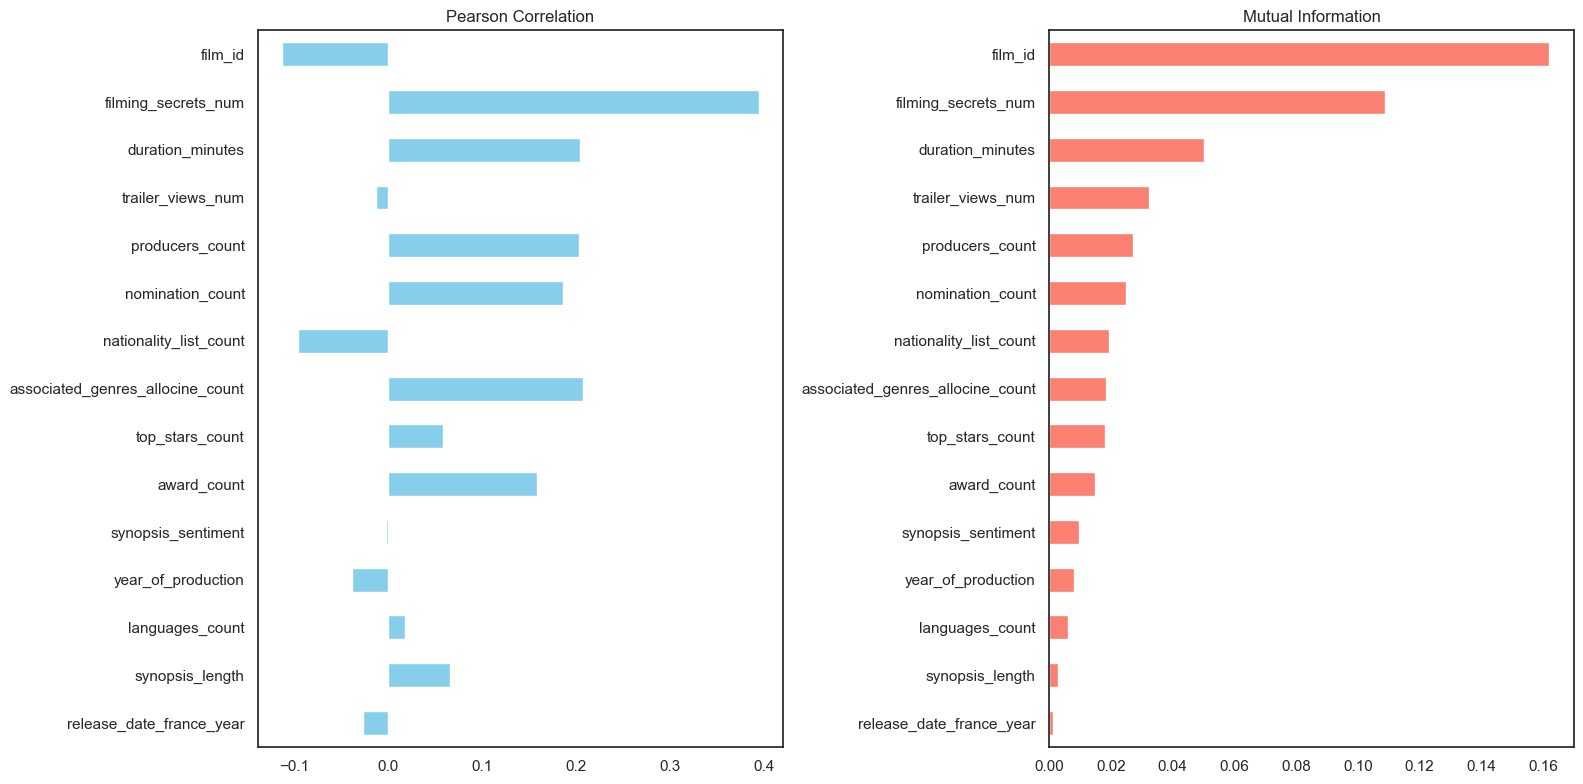

In [19]:
from sklearn.feature_selection import mutual_info_regression
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate Pearson correlation with the target
correlations = df_corr.corr()['opening_week_france_num'].drop('opening_week_france_num')

# Calculate Mutual Information with the target
mi = mutual_info_regression(X_scaled, y.loc[X_scaled.index])
mi_series = pd.Series(mi, index=X_scaled.columns)

# Combine into a DataFrame
comparison_df = pd.DataFrame({
    'Pearson Correlation': correlations,
    'Mutual Information': mi_series
}).sort_values('Mutual Information', ascending=True)

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
comparison_df['Pearson Correlation'].plot.barh(ax=axes[0], color='skyblue', title='Pearson Correlation')
comparison_df['Mutual Information'].plot.barh(ax=axes[1], color='salmon', title='Mutual Information')
plt.tight_layout()
plt.show()


#### Select initial features for model training

In [ ]:
df_model = df[[
    # Target 
    'opening_week_france_num',
    
    # Numerical predictors (continuous & standard scaled)
    'film_id', 'filming_secrets_num', 'duration_minutes',
    'trailer_views_num', 'producers_count', 'nomination_count',
    'award_count', 'associated_genres_allocine_count',
    'nationality_list_count', 

    # Experimental predictor (label encoded & standard scaled)
    'film_title',
    
    # Catgegorical predictors (binary or categorical)
    'main_genre_jpboxoffice', 'duration_classified',
    'release_timing_category', 'synopsis_length_categorized', 'synopisis_sentiment_categorized', 
    'age_class_grouped', 'director', 

    'nomination_categorized', 'award_categorized', 

    'top_stars_list', 'associated_genres_allocine_list', 'producers_list', 
    'languages_list', 'nationality_list',
]].copy()

#### Fill missing values with imputer

In [23]:
df.isna().sum()

film_id                                0
film_title                             0
year_of_production                     0
release_date_france_year            3009
release_date_france_month           3009
release_season                         0
nationality_list                       0
nationality_list_count                 0
languages_list                         0
languages_count                        0
director                               6
top_stars_list                         0
top_stars_count                        0
producers_list                         0
producers_count                        0
main_genre_jpboxoffice                 0
associated_genres_allocine_list        0
associated_genres_allocine_count       0
broadcast_category                     0
distributor                          150
age_class_grouped                      0
synopsis                               3
synopsis_length                        0
synopsis_sentiment                     0
filming_secrets_

In [ ]:
# Fill missing numerical fields with median
numerical_cols_with_na = ['duration_minutes', 'trailer_views_num']

# Option 2: fill multiple columns with their median values
for col in ['budget', 'duration_minutes', 'trailer_views_num']:
    df_model[col] = df_model[col].fillna(df_model[col].median())

#### Label encode film_title

In [20]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder for 'film_title' and 'release_date_france'
film_title_label_encoded = LabelEncoder()
release_date_label_encoded = LabelEncoder()

# Label encode the 'film_title' and 'release_date_france' columns
df_model['film_title_encoded'] = film_title_label_encoded.fit_transform(df_model['film_title'])

# Drop the original columns 'film_title' and 'release_date_france' if desired
df_model.drop(['film_title'], axis=1, inplace=True)

# Output the final dataframe
# df_model.head()

#### Standard scale numerical features

In [21]:
from sklearn.preprocessing import StandardScaler

# Define continuous columns to scale
continuous_cols = ['film_id', 'budget', 'filming_secrets_num', 'duration_minutes',
    'trailer_views_num', 'producers_count', 'nomination_count',
    'award_count', 'associated_genres_allocine_count',
    'nationality_list_count', 'film_title_encoded'
]

# Create a copy of the original dataframe for transformations
df_model_copy = df_model.copy()

# Apply standard scaling to continuous columns
scaler = StandardScaler()
df_model_copy[continuous_cols] = scaler.fit_transform(df_model_copy[continuous_cols])

#### Convert categories to category dtypes

In [22]:
categorical_cols = [
    'budget_categorized', 'budget_impact_categorized', 'main_genre_jpboxoffice',
    'duration_classified', 'release_timing_category', 'synopsis_length_categorized',
    'synopisis_sentiment_categorized', 'age_class_grouped', 'director'
]

# Convert each column to category using a lambda function
df_model_copy[categorical_cols] = df_model_copy[categorical_cols].apply(lambda col: col.astype('category'))

#### Explode stringified lists and drop columns

In [23]:
from sklearn.preprocessing import MultiLabelBinarizer
import ast

# Function to convert stringified lists into actual lists
def convert_string_to_list(stringified_list):
    return ast.literal_eval(stringified_list)

# Convert the stringified lists to actual lists
df_model_copy['top_stars_list'] = df_model_copy['top_stars_list'].apply(convert_string_to_list)
df_model_copy['associated_genres_allocine_list'] = df_model_copy['associated_genres_allocine_list'].apply(convert_string_to_list)
df_model_copy['languages_list'] = df_model_copy['languages_list'].apply(convert_string_to_list)
df_model_copy['nationality_list'] = df_model_copy['nationality_list'].apply(convert_string_to_list)
df_model_copy['producers_list'] = df_model_copy['producers_list'].apply(convert_string_to_list)

# Initialize MultiLabelBinarizer for each of the list columns
mlb_top_stars = MultiLabelBinarizer()
mlb_associated_genres = MultiLabelBinarizer()
mlb_languages = MultiLabelBinarizer()
mlb_nationality = MultiLabelBinarizer()
mlb_producers = MultiLabelBinarizer()

# Apply MultiLabelBinarizer to each list column
top_stars_encoded = pd.DataFrame(mlb_top_stars.fit_transform(df_model_copy['top_stars_list']),
                                 columns=mlb_top_stars.classes_)
associated_genres_encoded = pd.DataFrame(mlb_associated_genres.fit_transform(df_model_copy['associated_genres_allocine_list']),
                                         columns=mlb_associated_genres.classes_)
languages_encoded = pd.DataFrame(mlb_languages.fit_transform(df_model_copy['languages_list']),
                                 columns=mlb_languages.classes_)
nationality_encoded = pd.DataFrame(mlb_nationality.fit_transform(df_model_copy['nationality_list']),
                                   columns=mlb_nationality.classes_)
producers_encoded = pd.DataFrame(mlb_producers.fit_transform(df_model_copy['producers_list']),
                                 columns=mlb_producers.classes_)

# Remove duplicates from the columns
producers_encoded = producers_encoded.loc[:, ~producers_encoded.columns.duplicated()]

top_stars_encoded.columns = [f'star_{col}' for col in top_stars_encoded.columns]
associated_genres_encoded.columns = [f'genre_{col}' for col in associated_genres_encoded.columns]
languages_encoded.columns = [f'lang_{col}' for col in languages_encoded.columns]
nationality_encoded.columns = [f'nat_{col}' for col in nationality_encoded.columns]
producers_encoded.columns = [f'prod_{col}' for col in producers_encoded.columns]

# Drop the original list columns from df_model
df_model_copy.drop(['top_stars_list', 'associated_genres_allocine_list', 'languages_list', 
               'nationality_list', 'producers_list'], axis=1, inplace=True)

# Concatenate the encoded columns with df_model
df_model_final = pd.concat([
    df_model_copy,
    top_stars_encoded,
    associated_genres_encoded,
    languages_encoded,
    nationality_encoded,
    producers_encoded
], axis=1)

# Output the final dataframe
# df_model_final.head()

#### Declare predictor and target variables

In [24]:
X = df_model_final.drop('opening_week_france_num', axis=1)
y = df_model_final['opening_week_france_num']

#### Train and test LGBM model

In [39]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Split the data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Clean feature names to remove unsupported characters
X_train.columns = X_train.columns.str.replace(r'[^a-zA-Z0-9_]', '_', regex=True)
X_test.columns = X_test.columns.str.replace(r'[^a-zA-Z0-9_]', '_', regex=True)

# Remove duplicate columns from the feature set
X_train = X_train.loc[:, ~X_train.columns.duplicated()]
X_test = X_test.loc[:, ~X_test.columns.duplicated()]

# Define model
lgb_model = lgb.LGBMRegressor(boosting_type= 'dart',
                            n_jobs = 7,
                            bagging_fraction=0.8, 
                            bagging_freq=1,
                            feature_fraction=0.8, 
                            importance_type='gain',
                            min_child_weight=0.1, 
                            min_split_gain=0.1,
                            objective='rmse',
                            subsample=1.0,
                            learning_rate=0.2777,
                            n_estimators= 800,
                            )

lgb_model.fit(X_train, y_train)

lgb_train_score = lgb_model.score(X_train, y_train)

print("Training Score:", round(lgb_train_score, 2))

# Make predictions on the test set
y_pred = lgb_model.predict(X_test)

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE = {mae:.2f}")

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)
print(f"MSE: {mse}")

# Calculate RMSE
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")

# Calculate R2
r2 = r2_score(y_test, y_pred)
print(f"R2 Score: {r2}")

# Store model parameters in a DataFrame
best_lgb_params = lgb_model.get_params()  # Get model's hyperparameters
best_lgb_params_df = pd.DataFrame([best_lgb_params])

print("Training terminated CSV successfully!")

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead 

#### Train and test XGBoost model

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Split the data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Clean feature names to remove unsupported characters
X_train.columns = X_train.columns.str.replace(r'[^a-zA-Z0-9_]', '_', regex=True)
X_test.columns = X_test.columns.str.replace(r'[^a-zA-Z0-9_]', '_', regex=True)

# Remove duplicate columns from the feature set
X_train = X_train.loc[:, ~X_train.columns.duplicated()]
X_test = X_test.loc[:, ~X_test.columns.duplicated()]

# Initialize the XGBoost model
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',  # Using MSE as the loss function for regression
    eval_metric='rmse',            # Adding RMSE as the evaluation metric
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    colsample_bytree=0.3,
    alpha=10,
    random_state=42,
    enable_categorical=True
)

# Train the model on the training data
xgb_model.fit(X_train, y_train, verbose=True)

xgb_train_score = xgb_model.score(X_train, y_train)

print("Training Score:", round(xgb_train_score, 2))

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)
print(f"MSE: {mse}")

# Calculate RMSE
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE = {mae:.2f}")

# Calculate RMSE
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")

# Calculate R-squared (R2) score
r2 = r2_score(y_test, y_pred)
print(f"R2 Score: {r2}")

print("Training terminated CSV successfully!")

Training Score: 0.95
MSE: 51620388864.0
MAE = 112861.83
RMSE: 227201.20788411316
R2 Score: 0.561471700668335
Training terminated CSV successfully!


#### Train and test Random Forest Model

In [42]:
from sklearn.ensemble import RandomForestRegressor

df_model_final_2 = df_model_final.copy()

# Define the list of categorical columns
categorical_cols = [
    'budget_categorized', 'budget_impact_categorized', 'main_genre_jpboxoffice',
    'duration_classified', 'release_timing_category', 'synopsis_length_categorized',
    'synopisis_sentiment_categorized', 'age_class_grouped', 'director'
]

# Convert the categorical columns to category type
df_model_final_2[categorical_cols] = df_model_final_2[categorical_cols].apply(lambda col: col.astype('category'))

# One-hot encode the categorical columns
df_model_final_2 = pd.get_dummies(df_model_final_2, columns=categorical_cols, drop_first=True)

# Split the data into training and testing sets (80/20 split)
X = df_model_final_2.drop(columns=['opening_week_france_num']) 
y = df_model_final_2['opening_week_france_num']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Clean feature names to remove unsupported characters
X_train.columns = X_train.columns.str.replace(r'[^a-zA-Z0-9_]', '_', regex=True)
X_test.columns = X_test.columns.str.replace(r'[^a-zA-Z0-9_]', '_', regex=True)

# Remove duplicate columns from the feature set
X_train = X_train.loc[:, ~X_train.columns.duplicated()]
X_test = X_test.loc[:, ~X_test.columns.duplicated()]

# Initialize the Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=100,            # Number of trees in the forest
    max_depth=6,                 # Maximum depth of the trees
    random_state=42,             # Ensures reproducibility
    n_jobs=-1                    # Use all available cores for training
)

# Train the model on the training data
rf_model.fit(X_train, y_train)

# Training score (R^2) on the training set
rf_train_score = rf_model.score(X_train, y_train)

print("Training Score:", round(rf_train_score, 2))

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)
print(f"MSE: {mse}")

# Calculate MAE (Mean Absolute Error)
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE = {mae:.2f}")

# Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")

# Calculate R-squared (R2) score
r2 = r2_score(y_test, y_pred)
print(f"R2 Score: {r2}")

print("Training terminated successfully!")

Training Score: 0.67
MSE: 54914423678.176125
MAE = 127974.61
RMSE: 234338.2676350069
R2 Score: 0.4385485435482196
Training terminated successfully!


#### Check analysis notebook to delete the ECD figures

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV

# Split the data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Clean feature names to remove unsupported characters
X_train.columns = X_train.columns.str.replace(r'[^a-zA-Z0-9_]', '_', regex=True)
X_test.columns = X_test.columns.str.replace(r'[^a-zA-Z0-9_]', '_', regex=True)

# Remove duplicate columns from the feature set
X_train = X_train.loc[:, ~X_train.columns.duplicated()]
X_test = X_test.loc[:, ~X_test.columns.duplicated()]

# Define base model
base_lgb_model = lgb.LGBMRegressor(boosting_type='dart', n_jobs=-1, objective='rmse')

# Define parameter grid for GridSearch
param_grid = {
    'n_estimators': [500, 1200],
    'learning_rate': [0.05],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

# Use GridSearchCV
grid_search = GridSearchCV(
    estimator=base_lgb_model,
    param_grid=param_grid,
    cv=3,
    scoring='neg_root_mean_squared_error',  # Scoring with RMSE
    verbose=2,
    n_jobs=-1
)

# Fit Grid Search
grid_search.fit(X_train, y_train)

# Best model from grid search
best_lgb_model = grid_search.best_estimator_

# Training score
lgb_train_score = best_lgb_model.score(X_train, y_train)
print("Training Score:", round(lgb_train_score, 2))

# Make predictions
y_pred = best_lgb_model.predict(X_test)

# Evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE = {mae:.2f}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R2 Score: {r2}")

# Best parameters
best_lgb_params = grid_search.best_params_
best_lgb_params_df = pd.DataFrame([best_lgb_params])
print("Best Hyperparameters from Grid Search:")
print(best_lgb_params_df)

print("Training terminated with Grid Search successfully!")
